In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

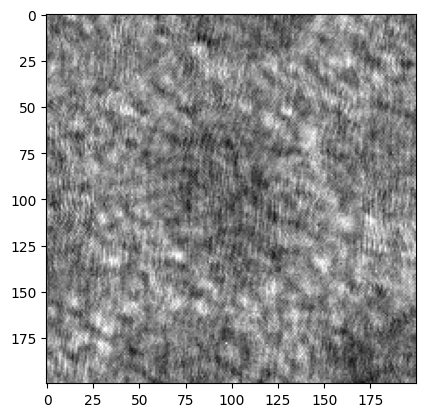

In [5]:
img_path = r"C:\Users\penda\Documents\Study Materials\Image Processing\PROJECT\PROJECT DATASET\Images\TEM39\TEM39_crop2.jpg"
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")

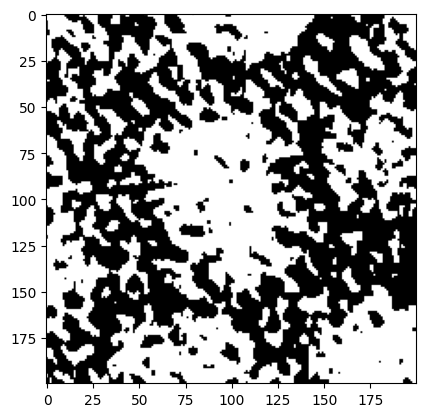

In [6]:
# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

_, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)
plt.imshow(thresh, cmap="gray")

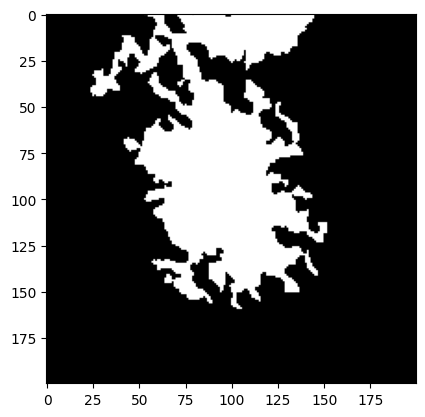

In [7]:
contours, hierachy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnt = sorted(contours, key=cv2.contourArea)[-1]
mask = np.zeros(image.shape[:2], dtype="uint8")

maskedFinal = cv2.drawContours(mask, [cnt], -1, (255, 255, 255), -1)
plt.imshow(maskedFinal, cmap="gray")

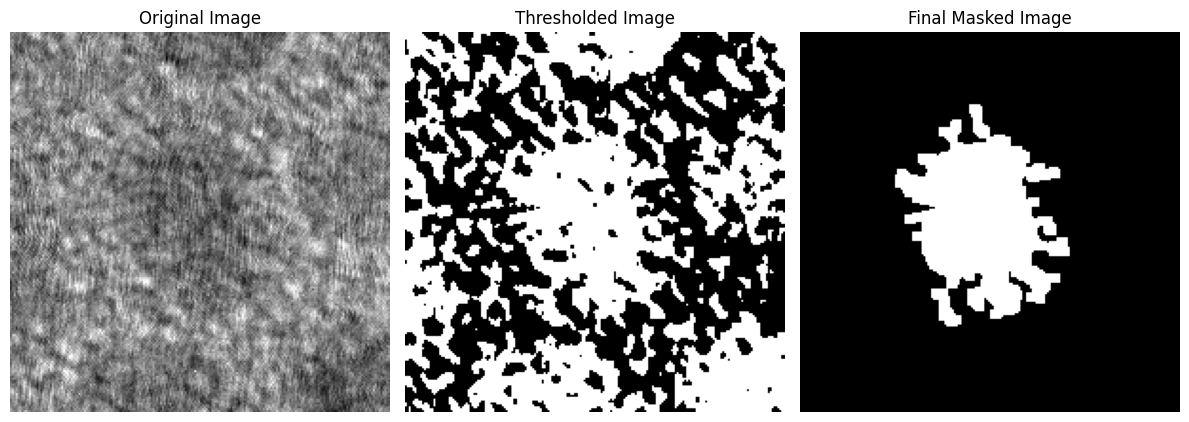

In [8]:
# Read the image and convert to grayscale
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding using the mean value
_, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)

# Apply Morphological Opening to remove small patches
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours in the processed image
contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by size (retain the largest)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0] if contours else None  # Select the largest contour

# Create a blank mask
mask = np.zeros_like(gray, dtype="uint8")

# Draw the largest contour onto the mask
if largest_contour is not None:
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Final Masked Image")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


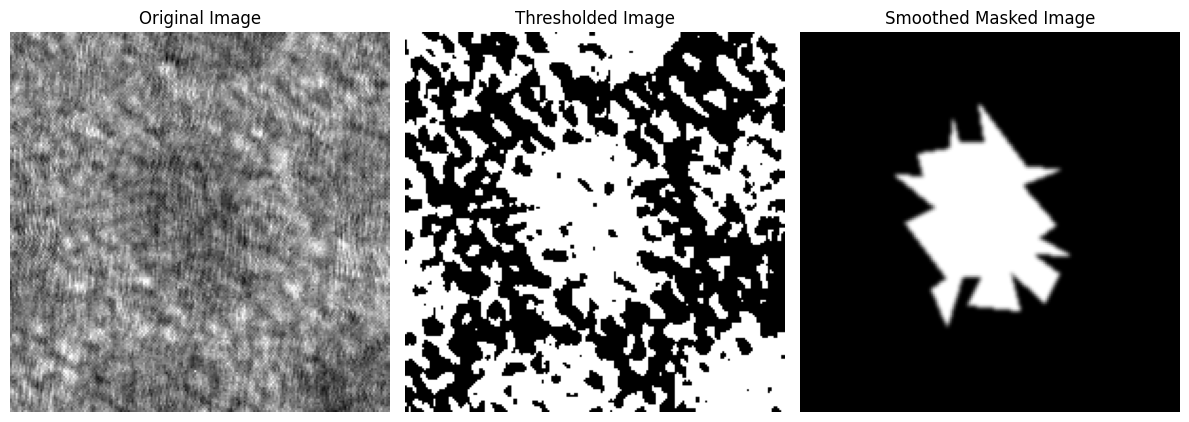

In [9]:
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding using the mean value
_, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)

# Apply Morphological Opening to remove small patches
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours in the processed image
contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours by size (retain the largest)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
largest_contour = contours[0] if contours else None  # Select the largest contour

# Create a blank mask
mask = np.zeros_like(gray, dtype="uint8")

if largest_contour is not None:
    # Smooth the contour using contour approximation
    epsilon = 0.01 * cv2.arcLength(largest_contour, True)
    smoothed_contour = cv2.approxPolyDP(largest_contour, epsilon, True)

    # Draw the smoothed contour onto the mask
    cv2.drawContours(mask, [smoothed_contour], -1, (255), thickness=cv2.FILLED)

    # Apply Gaussian Blur to smooth edges further
    mask = cv2.GaussianBlur(mask, (5, 5), 0)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Smoothed Masked Image")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


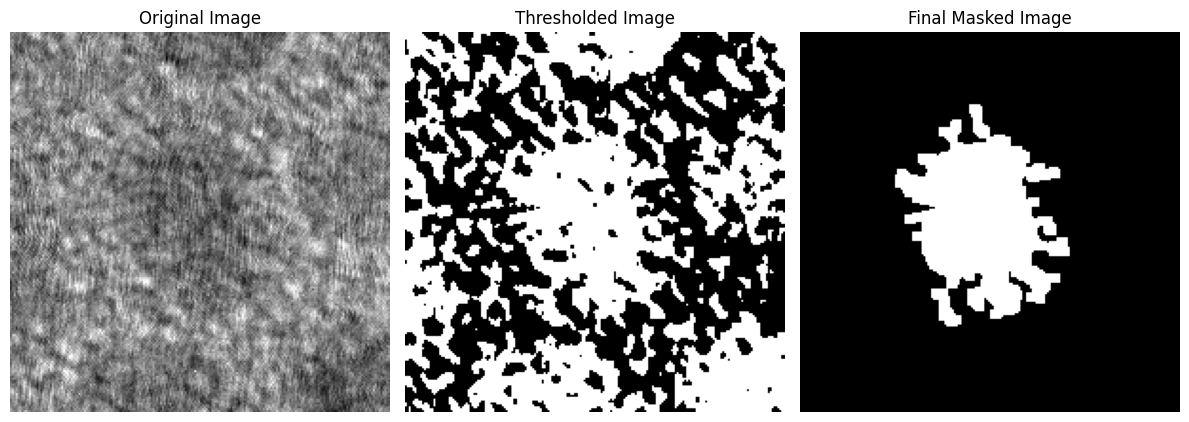

In [10]:
# Read the image and convert to grayscale
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Thresholding using the mean value
_, thresh = cv2.threshold(blurred, np.mean(blurred), 255, cv2.THRESH_BINARY_INV)

# Apply Morphological Opening to remove small patches
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Find contours in the processed image
contours, hierarchy = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Get the center of the image
image_center = (image.shape[1] // 2, image.shape[0] // 2)

# Function to calculate the distance from the contour's centroid to the image center
def contour_distance_to_center(contour):
    # Get the moments of the contour
    M = cv2.moments(contour)
    if M["m00"] != 0:
        # Calculate the centroid of the contour
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # Calculate the distance to the image center
        distance = np.sqrt((cX - image_center[0]) ** 2 + (cY - image_center[1]) ** 2)
        return distance
    return float('inf')  # Return a large value if the contour has zero area

# Sort contours first by distance to center, then by area (largest first)
contours_sorted = sorted(contours, key=lambda contour: (contour_distance_to_center(contour), -cv2.contourArea(contour)))

# Select the largest contour closest to the center
largest_contour_closest_to_center = contours_sorted[0] if contours_sorted else None

# Create a blank mask
mask = np.zeros_like(gray, dtype="uint8")

# Draw the largest contour closest to the center onto the mask
if largest_contour_closest_to_center is not None:
    cv2.drawContours(mask, [largest_contour_closest_to_center], -1, (255), thickness=cv2.FILLED)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Thresholded Image")
plt.imshow(thresh, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Final Masked Image")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()


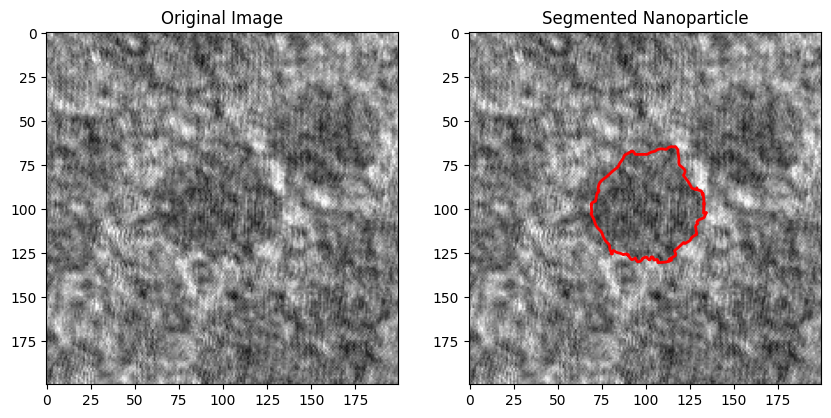

In [13]:
import cv2
import numpy as np
from skimage import img_as_ubyte
from skimage.filters import median
from skimage.morphology import disk
from skimage.segmentation import active_contour
from skimage import exposure
# from skimage.draw import circle
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

# Step 1: Brightness-Conserving Dynamic Histogram Equalization (BCDHE)
def brightness_conserving_dynamic_histogram_equalization(image):
    return exposure.equalize_adapthist(image, clip_limit=0.03)  # CLAHE as an approximation for BCDHE

# Step 2: Weighted Median Filter
def apply_weighted_median_filter(image):
    selem = disk(3)  # Structuring element for weighted median filter
    return median(image, selem)

# Step 3: Active Contour Segmentation (Level Set)
def active_contour_segmentation(image, init_contour):
    smoothed_image = gaussian_filter(image, sigma=1)  # Gaussian smoothing for better contours
    snake = active_contour(
        smoothed_image,
        init_contour,
        alpha=0.015,
        beta=10,
        gamma=0.001,
        w_edge=1,
        w_line=0
    )
    return snake

# Step 4: Intensity Level Adjustment
def adjust_intensity_levels(image):
    p2, p98 = np.percentile(image, (2, 98))
    adjusted_image = exposure.rescale_intensity(image, in_range=(p2, p98))
    return adjusted_image

# Main function to process the nanoparticle image
def segment_nanoparticle(image_path):
    # Load the image (convert to grayscale)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = img_as_ubyte(image) / 255.0  # Normalize to range [0, 1]

    # Step 1: Apply BCDHE
    enhanced_image = brightness_conserving_dynamic_histogram_equalization(image)

    # Step 2: Apply weighted median filter
    filtered_image = apply_weighted_median_filter(enhanced_image)

    # Step 3: Adjust intensity levels
    intensity_adjusted_image = adjust_intensity_levels(filtered_image)

    # Step 4: Initialize a circular contour for the active contour model
    s = np.linspace(0, 2 * np.pi, 400)
    r = 100 + 30 * np.sin(s)
    c = 100 + 30 * np.cos(s)
    init_contour = np.array([r, c]).T

    # Step 5: Active contour segmentation
    segmented_contour = active_contour_segmentation(intensity_adjusted_image, init_contour)

    # Visualization
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title('Segmented Nanoparticle')
    plt.imshow(image, cmap='gray')
    plt.plot(segmented_contour[:, 1], segmented_contour[:, 0], '-r', lw=2)  # Red contour
    plt.show()

# Example usage
segment_nanoparticle(r"C:\Users\penda\Documents\Study Materials\Image Processing\PROJECT\PROJECT DATASET\Images\TEM39\TEM39_crop1.jpg")


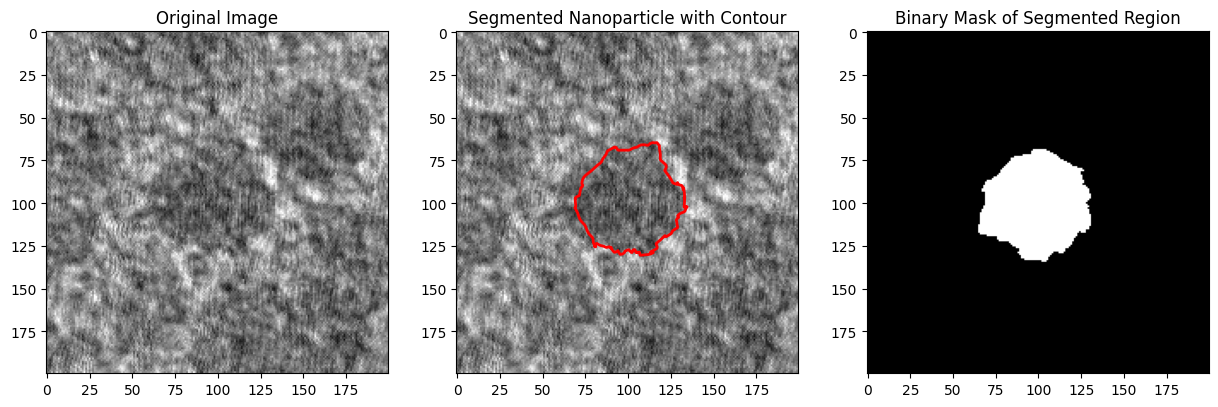

In [18]:
import cv2
import numpy as np
from skimage import img_as_ubyte
from skimage.filters import median
from skimage.morphology import disk
from skimage.segmentation import active_contour
from skimage import exposure
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Step 1: Brightness-Conserving Dynamic Histogram Equalization (BCDHE)
def brightness_conserving_dynamic_histogram_equalization(image):
    return exposure.equalize_adapthist(image, clip_limit=0.03)  # CLAHE as an approximation for BCDHE

# Step 2: Weighted Median Filter
def apply_weighted_median_filter(image):
    selem = disk(3)  # Structuring element for weighted median filter
    return median(image, selem)

# Step 3: Active Contour Segmentation (Level Set)
def active_contour_segmentation(image, init_contour):
    smoothed_image = gaussian_filter(image, sigma=1)  # Gaussian smoothing for better contours
    snake = active_contour(
        smoothed_image,
        init_contour,
        alpha=0.015,
        beta=10,
        gamma=0.001,
        w_edge=1,
        w_line=0
    )
    return snake

# Step 4: Intensity Level Adjustment
def adjust_intensity_levels(image):
    p2, p98 = np.percentile(image, (2, 98))
    adjusted_image = exposure.rescale_intensity(image, in_range=(p2, p98))
    return adjusted_image

# Step 5: Create Binary Mask
def create_binary_mask(image, contour):
    mask = np.zeros_like(image, dtype=np.uint8)
    contour_points = np.round(contour).astype(np.int32)
    cv2.fillPoly(mask, [contour_points], 255)  # Fill contour region with white
    return mask

# Main function to process the nanoparticle image
def segment_nanoparticle(image_path):
    # Load the image (convert to grayscale)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = img_as_ubyte(image) / 255.0  # Normalize to range [0, 1]

    # Step 1: Apply BCDHE
    enhanced_image = brightness_conserving_dynamic_histogram_equalization(image)

    # Step 2: Apply weighted median filter
    filtered_image = apply_weighted_median_filter(enhanced_image)

    # Step 3: Adjust intensity levels
    intensity_adjusted_image = adjust_intensity_levels(filtered_image)

    # Step 4: Initialize a circular contour for the active contour model
    s = np.linspace(0, 2 * np.pi, 400)
    r = 100 + 30 * np.sin(s)
    c = 100 + 30 * np.cos(s)
    init_contour = np.array([r, c]).T

    # Step 5: Active contour segmentation
    segmented_contour = active_contour_segmentation(intensity_adjusted_image, init_contour)

    # Step 6: Create binary mask
    binary_mask = create_binary_mask(intensity_adjusted_image, segmented_contour)

    # Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Segmented Nanoparticle with Contour')
    plt.imshow(image, cmap='gray')
    plt.plot(segmented_contour[:, 1], segmented_contour[:, 0], '-r', lw=2)  # Red contour

    plt.subplot(1, 3, 3)
    plt.title('Binary Mask of Segmented Region')
    plt.imshow(binary_mask, cmap='gray')

    plt.show()

# Example usage
segment_nanoparticle(r"C:\Users\penda\Documents\Study Materials\Image Processing\PROJECT\PROJECT DATASET\Images\TEM39\TEM39_crop1.jpg")